## Deconvolution

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [80]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'

In [81]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

### Define functions

In [134]:
def gaussian(x, mu, sig):
    '''
    Normalized Gaussian function
    '''
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    '''
    smeared_response = np.zeros(len(electron_energies))
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        ampl = gaussian(neutron_energy, mu, sigma)
        smeared_response += bin_width*ampl*response[i]
    return smeared_response

def get_neutron_spectrum_interpolated(energy_list, a, mu, sigma):
    '''
    Interpolate the function that we get from 'get_neutron_spectrum'  to fit 'energy_list'
    '''
    smeared_response = get_neutron_spectrum(mu, sigma)
    return a * np.interp(energy_list, 1000*electron_energies, smeared_response)

def get_neutron_spectrum_interpolated_2(energy_list, a1, mu1, sigma1, a2, mu2, sigma2):
    '''
    Two copies of get_neutron_spectrum_interpolated for fitting of two energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2))

def get_chi_sq(y_data, y_err, y_fit):
    return sum((y_fit - y_data)**2/(y_err**2))

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    import matplotlib as mpl
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))


### A first trial: 'manual minimization'

In [83]:
# fit_range = [450, 900]

# # Selection: boolean array for the energies
# sel = (x3 > fit_range[0]) & (x3 < fit_range[1])

# # Select data piece to fit
# x = x3[sel]
# y_data = f3[sel]
# y_err = np.sqrt(y_data)


# best_mu = 0.
# best_sigma = 0.
# best_chi2 = np.inf
# best_scale = 0.

# # Worst minimizer routine EVER: just loop over all values :)
# # Oh, and just to add to this: the scaling is just estimated based on same number of events
# for mu in np.arange(2.3,2.5, 0.01):
#     for sigma in np.arange(0.15,0.25,0.01):
#         y_fit = get_neutron_spectrum_interpolated(x, 1., mu, sigma)
#         scale_guess = sum(y_data)/sum(y_fit)
#         if (get_chi_sq(y_data, y_err, scale_guess*y_fit)) < best_chi2:
#             best_mu = mu
#             best_sigma = sigma
#             best_y_fit = scale_guess*y_fit
#             best_scale = scale_guess
#             best_chi2 = (get_chi_sq(y_data, y_err, scale_guess*y_fit))

# print(best_mu)
# print(best_sigma)
print("This cell has been depricated!")

This cell has been depricated!


### Proper minimization

Here are the spectra that we can fit:

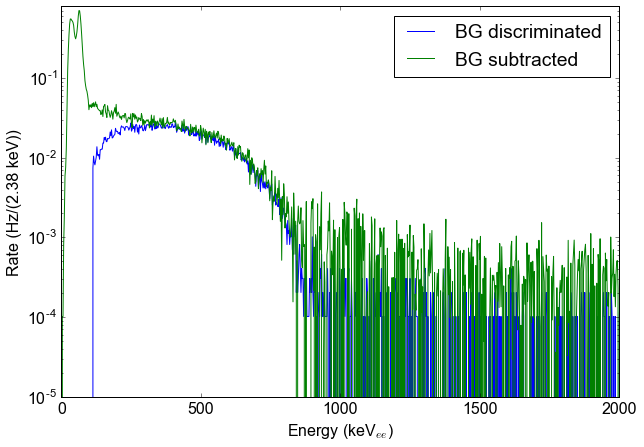

In [135]:
plt.plot(x1, 1/ng_livetimes_0[0]*f1, label='BG discriminated')
plt.plot(e_scale, fg_0_sub, label= 'BG subtracted')
plt.ylabel('Rate (Hz/(2.38 keV))')
plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0.00001, 0.8)
plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()

### Fit BG rejected spectrum

In [85]:
from iminuit import Minuit

In [86]:
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2FuncFull:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2    

In [91]:
# Select the data to fit
sel = (x3 > 450) & (x3 < 800)
x = x3[sel]
y_data = f3[sel]
y_err = f3_err[sel]

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(a=100, mu=2.5, sigma=0.5, error_a = 1, error_mu = 1, error_sigma = 1)
# Initialize minimizer and minimize
m1 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m1.migrad();
print(m1.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:13: InitialParamWarning: errordef is not given. Default to 1.


FCN = 44.31936867844463 
 TOTAL NCALL = 113 
 NCALLS = 113 
 
 
 EDM = 3.966138081001236e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,106.94,1.42451,0,0,,,
2,mu,2.3701,0.00601247,0,0,,,
3,sigma,0.207618,0.00949994,0,0,,,


{'mu': 2.3700981588247565, 'sigma': 0.20761823594218934, 'a': 106.9395528608409}


In [247]:
# Select the data to fit
sel = (x3 > 800) & (x3 < 1200)
x = x3[sel]
y_data = f3[sel]
y_err = f3_err[sel]

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(a=10, mu=14, sigma=1, error_a = 1, error_mu = 1, error_sigma = 1)
# Initialize minimizer and minimize
m2 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m2.migrad();
print(m2.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:13: InitialParamWarning: errordef is not given. Default to 1.


FCN = 153.03046410906373 
 TOTAL NCALL = 8363 
 NCALLS = 8363 
 
 
 EDM = 0.00011889792427625641 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,2.65169e+19,1.95873e+19,0,0,,,
2,mu,-15.8067,0.218714,0,0,,,
3,sigma,2.18806,0.0256722,0,0,,,


{'mu': -15.806662461300844, 'sigma': 2.1880564000561327, 'a': 2.6516944041491132e+19}


In [213]:
# Select the data to fit
sel = (x3 > 450) & (x3 < 2000)
x = x3[sel]
y_data = f3[sel]
y_err = f3_err[sel]

# Initialize chi2 function
chi2 = Chi2FuncFull(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a1=281, mu1=2.36, sigma1=0.196, error_a1 = 0.1, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=79, mu2=16.2, sigma2=0.4, error_a2 = 0.1, error_mu2 = 0.1, error_sigma2 = 0.1)
# Initialize minimizer and minimize
m3 = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m3.migrad();
print(m3.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: InitialParamWarning: errordef is not given. Default to 1.


FCN = 443.7867939773334 
 TOTAL NCALL = 468 
 NCALLS = 468 
 
 
 EDM = 49456.596821122126 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,8756.61,85.4856,0,0,,,
2,mu1,2.36304,1.00001,0,0,,,
3,sigma1,0.195135,1.00001,0,0,,,
4,a2,648.584,10.3134,0,0,,,
5,mu2,16.1964,1,0,0,,,
6,sigma2,0.000114874,1,0,0,,,


{'sigma2': 0.00011487391084082533, 'sigma1': 0.19513487252857817, 'mu1': 2.363037040683425, 'mu2': 16.196367716076512, 'a1': 8756.614270239272, 'a2': 648.5838259829576}


### Plot the result

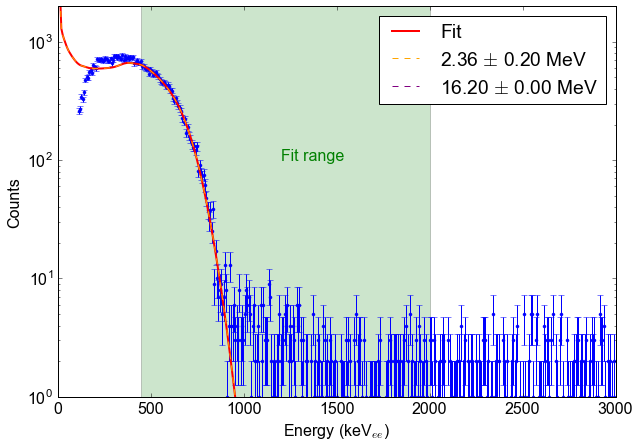

In [214]:
plt.errorbar(x3, f3, np.sqrt(f3), ls='None', marker='.')
plt.plot(x3, get_neutron_spectrum_interpolated_2(x3, **m3.values), color='red', lw=2,
        label='Fit')
plt.plot(x3, get_neutron_spectrum_interpolated(x3, m3.values['a1'], m3.values['mu1'], m3.values['sigma1'])
         , color='orange', lw=1, ls='--', 
         label='%.2f $\pm$ %.2f MeV' % (m3.values['mu1'],m3.values['sigma1']))
plt.plot(x3, get_neutron_spectrum_interpolated(x3, m3.values['a2'], m3.values['mu2'], m3.values['sigma2'])
         , color='purple', lw=1, ls='--', 
         label='%.2f $\pm$ %.2f MeV' % (m3.values['mu2'],m3.values['sigma2']))


# plt.axvline(450, color='green', ls='--')
# plt.axvline(2000, color='green', ls='--')

draw_box((450, 2000), (0, 5000), facecolor='green', alpha=0.2)
plt.text(1200, 100, 'Fit range', color='green')

plt.ylim(1,2000)
plt.xlim(0,3000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Counts')
plt.savefig('07_fit_spectrum.pdf', bbox_inches='tight')

### Fit spectrum for BG subtracted spectrum

We can play the same trick for the spectrum where we subtract background.

In [100]:
e_scale = np.array(e_scale)

In [225]:
# Select the data to fit
sel = (e_scale > 450) & (e_scale < 800)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.2, mu=2.4, sigma=0.196, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01)
# Initialize minimizer and minimize
m4 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m4.migrad();
print(m4.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: InitialParamWarning: errordef is not given. Default to 1.


FCN = 156.15599194907773 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = 6.003466475878596e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.327646,0.0069942,0,0,,,
2,mu,2.38357,0.0100408,0,0,,,
3,sigma,0.208624,0.0185423,0,0,,,


{'mu': 2.383574412502308, 'sigma': 0.20862418551813755, 'a': 0.327645503298747}


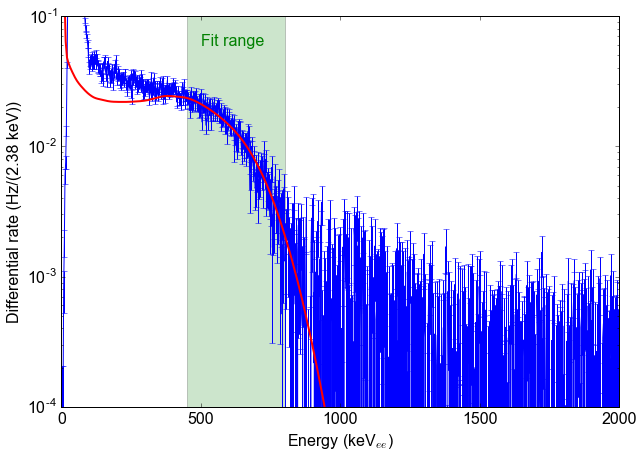

In [237]:
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err)
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **m4.values), color='red',lw=2)

plt.xlim(0,2000)
plt.yscale('log')
plt.ylim(0.0001,0.1)
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keV))')
draw_box((450, 800), (0, 0.1), facecolor='green', alpha=0.2)
plt.text(500, 0.06, 'Fit range', color='green')

### Fit double Gaussian

In [215]:
# Select the data to fit
sel = (e_scale > 450) & (e_scale < 800)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2FuncFull(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a1=0.04, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.04, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01)
# Initialize minimizer and minimize
m5 = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m5.migrad();
val5 = m5.values
print(val5)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:16: InitialParamWarning: errordef is not given. Default to 1.


FCN = 148.58766279097526 
 TOTAL NCALL = 720 
 NCALLS = 720 
 
 
 EDM = 4.604429040000161e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.186875,0.119067,0,0,,,
2,mu1,2.52409,0.142242,0,0,,,
3,sigma1,0.159594,0.129717,0,0,,,
4,a2,0.134074,0.116934,0,0,,,
5,mu2,2.22995,0.0493754,0,0,,,
6,sigma2,0.0648363,0.0575086,0,0,,,


{'sigma2': 0.06483625708895463, 'sigma1': 0.15959427414255467, 'mu1': 2.5240903466337294, 'mu2': 2.2299517095298818, 'a1': 0.18687529330043062, 'a2': 0.13407448576664707}


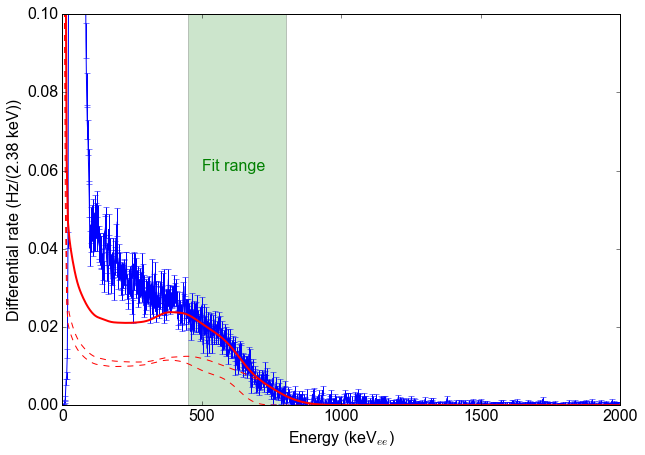

In [239]:
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err)
plt.plot(e_scale, 
         get_neutron_spectrum_interpolated(e_scale, m5.values['a1'], m5.values['mu1'], m5.values['sigma1']) + 
         get_neutron_spectrum_interpolated(e_scale, m5.values['a2'], m5.values['mu2'], m5.values['sigma2']),
         color='red',lw=2)
plt.plot(e_scale, 
         get_neutron_spectrum_interpolated(e_scale, m5.values['a1'], m5.values['mu1'], m5.values['sigma1']),
         color='red',ls='--')
plt.plot(e_scale, 
         get_neutron_spectrum_interpolated(e_scale, m5.values['a2'], m5.values['mu2'], m5.values['sigma2']),
         color='red',ls='--')
plt.xlim(0,2000)
#plt.yscale('log')
plt.ylim(0.0001,0.1)
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keV))')
draw_box((450, 800), (0, 0.1), facecolor='green', alpha=0.2)
plt.text(500, 0.06, 'Fit range', color='green')
plt.show()

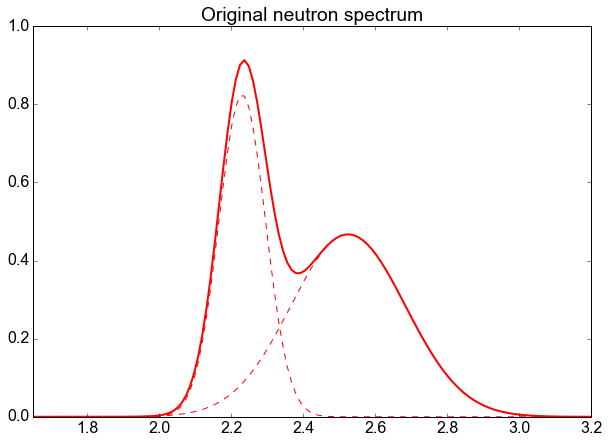

In [233]:
plt.plot(neutron_energies, val5['a1']*gaussian(neutron_energies, val5['mu1'],val5['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, val5['a2']*gaussian(neutron_energies, val5['mu2'],val5['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, val5['a1']*gaussian(neutron_energies, val5['mu1'],val5['sigma1']) +
         val5['a2']*gaussian(neutron_energies, val5['mu2'],val5['sigma2']),c='red',lw=2)
plt.xlim(1.65, 3.2)
plt.title('Original neutron spectrum')
